In [155]:
import pandas as pd
import numpy as np
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import folium
import matplotlib.pyplot as plt
from folium import plugins
import seaborn as sns

In [156]:
# Initialize Faker
fake = Faker()

# Set seed
seed = 42
np.random.seed(seed)
Faker.seed(seed)

In [157]:
# Parameters
num_samples = 5000
regions = ["Wan Chai", "Central and Western", "Eastern", "Southern",
           "Kowloon City", "Yau Tsim Mong", "Wong Tai Sin", "Sham Shui Po", "Kwun Tong",
           "Tsuen Wan", "North", "Sha Tin", "Islands", "Yuen Long", "Tai Po", "Tuen Mun", "Kwai Tsing", "Sai Kung"]
ethnicities = ["Chinese", "Filipinos", "South Asians", "Whites", "Other"]
eth_prob = [0.7, 0.05, 0.1, 0.1, 0.05]
sports = ["Football", "Basketball", "Tennis", "Badminton", "Swimming", "Jogging","Gymnastics", "Fencing", "Cycling", 
          "Dragon Boat", "Rugby", "Martial Arts"]
insured_amt = [300,500,800,1000,1500,2000,2500,3000]
insured_amt_prob = [0.4,0.3,0.15,0.1,0.03,0.01,0.005,0.005]

# pricepoint = insurance_amount * 2.5 + np.random.normal(loc=200, scale=500)

# Generate Data
data = []
for _ in range(num_samples):
    age = np.random.randint(18, 71)  # Using NumPy
    ethnicity = np.random.choice(ethnicities, p=eth_prob)
    gender = np.random.choice(['Male', 'Female'])  # Using NumPy
    income = np.random.choice(
                                [np.random.randint(20000, 35001), np.random.randint(35000, 55001), np.random.randint(55000, 80000)],
                                        p=[0.4, 0.5, 0.1]
                                     )
    district = np.random.choice(regions)  # Using NumPy
    insurance_coverage = np.random.choice(['yes', 'no'])  # Using NumPy
    insurance_amount = np.random.choice(insured_amt, p=insured_amt_prob)
    continuous_insurance_amount = np.interp(insurance_amount, 
                                                        [300, 3000], 
                                                        [300, 1000 + np.random.uniform(0, 1000)]) if insurance_coverage == 'yes' else 0  # Using NumPy
    sport = np.random.choice(sports)  # Using NumPy
    height = np.random.randint(140, 201)  # Using NumPy
    weight = height * 0.2 + np.random.normal(loc=45, scale=8)
    pricepoint = np.random.choice(
                                        [insurance_amount * 2 + np.random.normal(loc=150, scale=400), insurance_amount * 4 + np.random.normal(loc=300, scale=500)],
                                        p=[0.99, 0.01]
                                     ) if district in ["Wan Chai", "Central and Western", "Eastern", "Southern"] else np.nan
    
    # Determine the value for column "Region"
    if district in ["Wan Chai", "Central and Western", "Eastern", "Southern"]:
        region = "Hong Kong Island"
    elif district in ["Kowloon City", "Yau Tsim Mong", "Wong Tai Sin", "Sham Shui Po", "Kwun Tong"]:
        region = "Kowloon"
    else:
        region = "New Territories"
    
    data.append([age, ethnicity, gender, income, district, region, insurance_coverage, continuous_insurance_amount, sport, height, weight, pricepoint])

# Create DataFrame
columns = ["Age", "Ethnicity", "Gender", "Income", "District", "Region", "Insurance Coverage", 
           "Insurance Coverage Amount", "Sports", "Height", "Weight", "Pricepoint"]
df = pd.DataFrame(data, columns=columns)

# Convert the 'Income' column to float
df["Income"] = df["Income"].astype(float)

# Now perform the operation safely
df.loc[df["Region"] == "Kowloon", "Insurance Coverage Amount"] *= 0.65
df.loc[df["Region"] == "New Territories", "Insurance Coverage Amount"] *= 0.45

df.to_csv('dataset.csv', index=False)

In [158]:
df

,Age,Ethnicity,Gender,Income,District,Region,Insurance Coverage,Insurance Coverage Amount,Sports,Height,Weight,Pricepoint
0,56,South Asians,Male,33418.0,North,New Territories,yes,286.796751,Fencing,142,69.644205,NaN
1,38,Chinese,Female,41396.0,Tsuen Wan,New Territories,no,0.000000,Tennis,183,85.940480,NaN
2,69,Chinese,Male,23556.0,Wong Tai Sin,Kowloon,no,0.000000,Martial Arts,153,70.797969,NaN
3,70,Chinese,Female,25486.0,Yuen Long,New Territories,yes,135.000000,Basketball,145,81.579519,NaN
4,59,Chinese,Male,60675.0,Southern,Hong Kong Island,no,0.000000,Fencing,153,67.527317,1116.682315
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,61,Whites,Female,20029.0,North,New Territories,yes,208.959590,Badminton,174,96.507643,NaN
4996,64,Chinese,Female,54762.0,Sha Tin,New Territories,yes,179.956582,Cycling,149,81.905761,NaN
4997,68,Chinese,Male,26268.0,Yuen Long,New Territories,yes,135.000000,Basketball,178,82.673436,NaN
4998,43,Chinese,Male,26328.0,Eastern,Hong Kong Island,yes,300.000000,Rugby,154,70.394094,1372.167333


In [159]:
hkisland_df = df[df["Region"] == "Hong Kong Island"]
kowloon_df = df[df["Region"] == "Kowloon"]
nt_df = df[df["Region"] == "New Territories"]

# Make sure the original df is split complete to HKIsland, Kowloon and New Territories
assert hkisland_df.shape[0] + kowloon_df.shape[0] + nt_df.shape[0] == df.shape[0]

Income Distribution

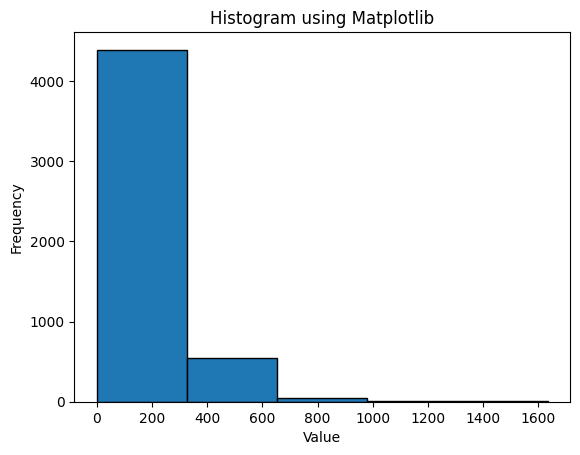

In [160]:
import matplotlib.pyplot as plt

# Sample data
data = df["Insurance Coverage Amount"]

# Create histogram
plt.hist(data, bins=5, edgecolor='black')

# Add titles and labels
plt.title('Histogram using Matplotlib')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show plot
plt.show()

Pricepoint Prediction (Random Forest)

In [161]:
# Preprocess data
X = hkisland_df.drop(columns=["Pricepoint"])
y = hkisland_df["Pricepoint"].dropna()

# Label encoding for categorical variables
X = pd.get_dummies(X, drop_first=True)
y = y[X.index]  # Align y with the non-NaN indices of X

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)

# Calculate mean
mean_value = np.mean(predictions)

# Calculate standard deviation
std_dev = np.std(predictions)

# Calculate quantiles (e.g., 25th, 50th, and 75th percentiles)
quantiles = np.quantile(predictions, [0.25, 0.5, 0.75])

# Display results
print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_dev}")
print(f"Quantiles (25th, 50th, 75th): {quantiles}")


Mean: 1357.3465496704796
Standard Deviation: 625.7424231522082
Quantiles (25th, 50th, 75th): [1024.79017392 1244.86606704 1468.6972029 ]


Mean Absolute Error (MAE): 524.2506316256248
Mean Squared Error (MSE): 547959.4132632809
R-squared (R²): 0.38969142839949933


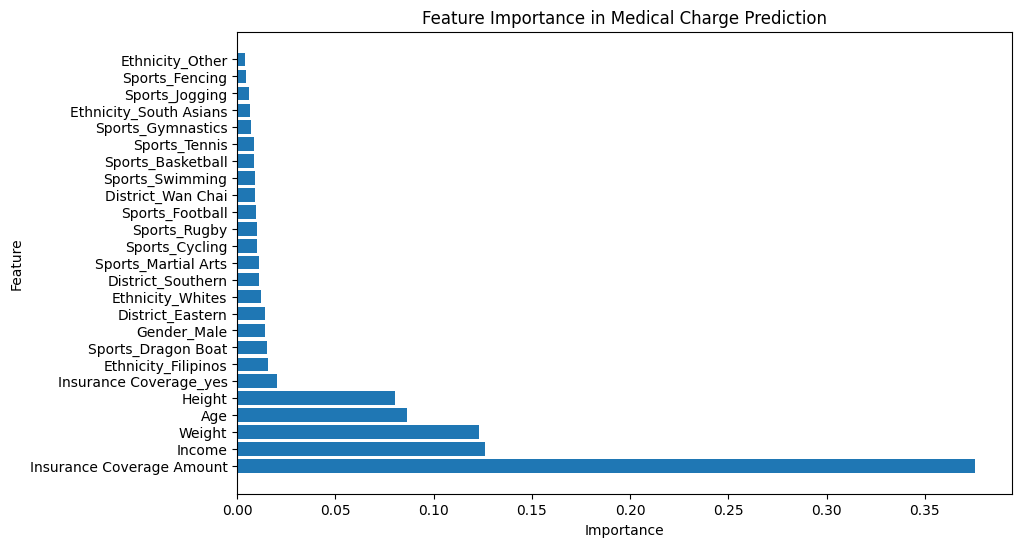

In [162]:
# Model Evaluation
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Display performance metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# Feature Importance
importance = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Medical Charge Prediction')
plt.show()

Pricepoint Prediction (Regression)

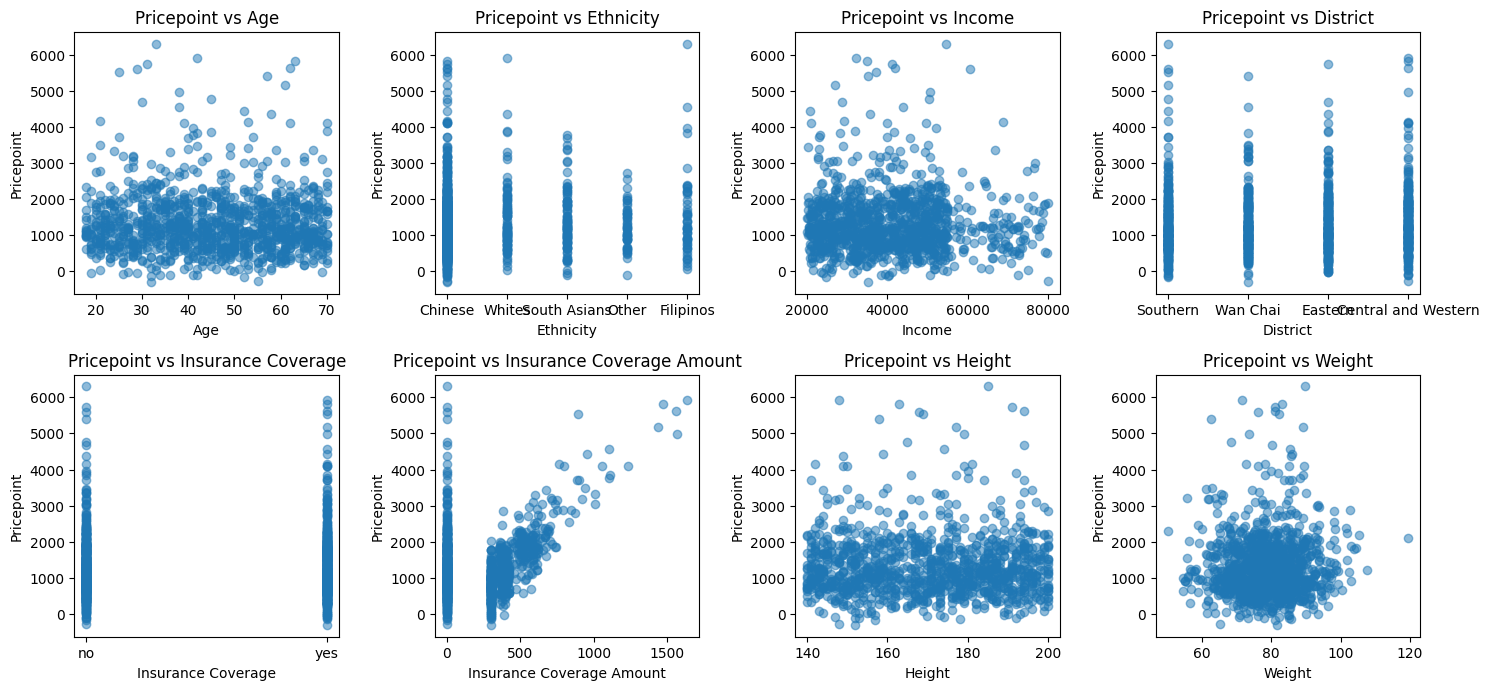

In [163]:
# List of features to plot against Medical Charge
features = hkisland_df.drop(columns=["Pricepoint", "Region", "Gender", "Sports"]).columns

# Set up the figure
plt.figure(figsize=(15, 10))

# Loop through each feature and create a scatter plot
for i, feature in enumerate(features):
    plt.subplot(3, 4, i + 1)  # Adjust the grid size as needed
    plt.scatter(hkisland_df[feature], hkisland_df["Pricepoint"], alpha=0.5)
    plt.title(f'Pricepoint vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Pricepoint')

# Adjust layout
plt.tight_layout()
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Pricepoint   No. Observations:                  893
Model:                            GLM   Df Residuals:                      870
Model Family:                Gaussian   Df Model:                           22
Link Function:               Identity   Scale:                      4.5276e+05
Method:                          IRLS   Log-Likelihood:                -7070.3
Date:                Mon, 21 Jul 2025   Deviance:                   3.9390e+08
Time:                        21:36:21   Pearson chi2:                 3.94e+08
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4479
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

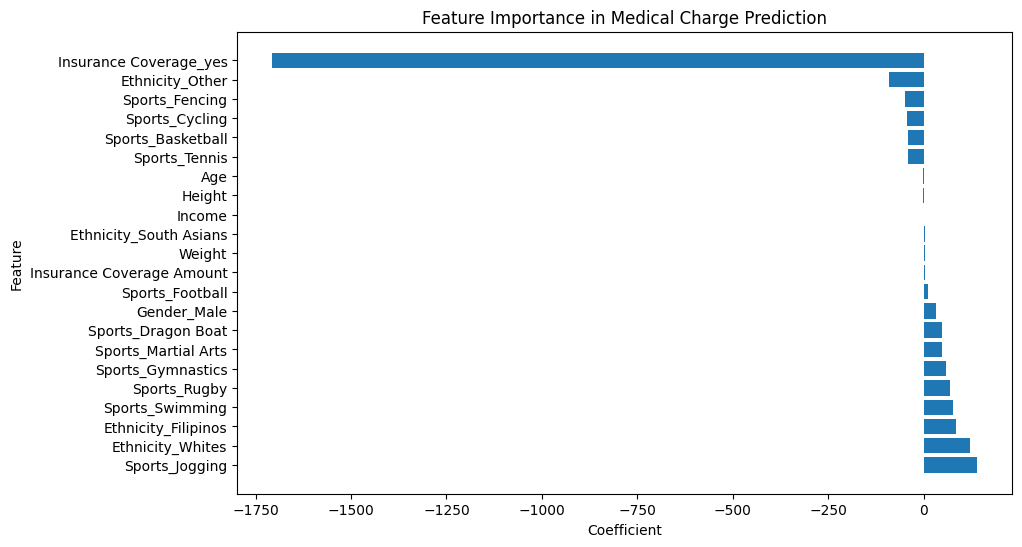

In [164]:
def price_prediction_feature_importance(dataframe):

    dataframe = dataframe.drop(columns=["District"])

    dataframe = pd.get_dummies(dataframe, columns=["Ethnicity", "Gender", "Region", "Insurance Coverage",
                   "Sports"], drop_first=True)

    boolean_columns = ['Ethnicity_Filipinos', 'Ethnicity_Other', 'Ethnicity_South Asians', 
                    'Ethnicity_Whites', 'Gender_Male', 
                    'Insurance Coverage_yes', 'Sports_Basketball', 
                    'Sports_Cycling', 'Sports_Dragon Boat', 
                    'Sports_Fencing', 'Sports_Football', 
                    'Sports_Gymnastics', 'Sports_Jogging', 
                    'Sports_Martial Arts', 'Sports_Rugby', 
                    'Sports_Swimming', 'Sports_Tennis']

    for column in boolean_columns:
        dataframe[column] = dataframe[column].astype(int)

    # Preprocess data
    X = dataframe.drop(columns=["Pricepoint"])
    y = dataframe["Pricepoint"].dropna()


    # Align y with the non-NaN indices of X
    X = X.loc[y.index]

    # Convert categorical variables to dummy variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Prepare the data for the GLM
    X_sm = sm.add_constant(X_train)  # Add intercept

    # Fit the GLM (using Gaussian family for linear regression)
    glm_model = sm.GLM(y_train, X_sm, family=sm.families.Gaussian()).fit()

    # Print the summary of the model
    print(glm_model.summary())


    # Predictions
    X_sm_new = sm.add_constant(X_test)  # Add intercept
    predictions = glm_model.predict(X_sm_new)


    # Model Evaluation
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Display performance metrics
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")

    # Coefficients as feature importance
    coefficients = glm_model.params
    feature_names = X.columns


    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients[1:]})
    importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Coefficient'])
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.title('Feature Importance in Medical Charge Prediction')
    plt.show()

    return glm_model,predictions

glm_model,predictions = price_prediction_feature_importance(hkisland_df)


In [165]:
def mean_sd_qt_calculation(predictions):
    # Calculate mean
    mean_value = np.mean(predictions)

    # Calculate standard deviation
    std_dev = np.std(predictions)

    # Calculate quantiles (e.g., 25th, 50th, and 75th percentiles)
    quantiles = np.quantile(predictions, [0.25, 0.5, 0.75])
    quantiles = [round(x,-1) for x in quantiles.tolist()]

    # Display results
    # print(f"Mean: {round(mean_value,-1)}")
    # print(f"Standard Deviation: {round(std_dev,-1)}")
    # print(f"Quantiles (25th, 50th, 75th): {quantiles}")

    return {"Mean": round(mean_value,-1),
            "Standard Deviation": round(std_dev,-1),
            "Quantiles (25th, 50th, 75th)": quantiles
            }

mean_sd_qt_calculation(predictions)

{'Mean': np.float64(1360.0),
 'Standard Deviation': np.float64(600.0),
 'Quantiles (25th, 50th, 75th)': [1090.0, 1280.0, 1390.0]}

Price Prediction

In [166]:
dict_price_by_district = {}

for region in regions:
    df_by_region = df[df["District"] == region]
    df_copy = df_by_region.drop(columns=["District"])
    df_copy = pd.get_dummies(df_copy, columns=["Ethnicity", "Gender", "Region", "Insurance Coverage",
                    "Sports"], drop_first=True)

    boolean_columns = ['Ethnicity_Filipinos', 'Ethnicity_Other', 'Ethnicity_South Asians', 
                    'Ethnicity_Whites', 'Gender_Male', 
                    'Insurance Coverage_yes', 'Sports_Basketball', 
                    'Sports_Cycling', 'Sports_Dragon Boat', 
                    'Sports_Fencing', 'Sports_Football', 
                    'Sports_Gymnastics', 'Sports_Jogging', 
                    'Sports_Martial Arts', 'Sports_Rugby', 
                    'Sports_Swimming', 'Sports_Tennis']

    for column in boolean_columns:
        df_copy[column] = df_copy[column].astype(int)


    df_copy = sm.add_constant(df_copy)
    nt_predictions = glm_model.predict(df_copy.drop(columns=["Pricepoint"]))

    dict_price_by_district[region] = mean_sd_qt_calculation(nt_predictions)


# Create DataFrame
df_price_by_district = pd.DataFrame.from_dict(dict_price_by_district, orient='index')
df_price_by_district.index.name = 'District'
df_price_by_district.reset_index(inplace=True)
df_price_by_district = df_price_by_district.sort_values(by=['Mean', 'Standard Deviation'], ascending=[True, False]).reset_index(drop=True)


# Display the DataFrame
display(df_price_by_district)


,District,Mean,Standard Deviation,"Quantiles (25th, 50th, 75th)"
0,Tsuen Wan,800.0,530.0,"[270.0, 820.0, 1310.0]"
1,Islands,820.0,540.0,"[300.0, 770.0, 1330.0]"
2,North,820.0,530.0,"[310.0, 930.0, 1310.0]"
3,Tuen Mun,820.0,530.0,"[260.0, 880.0, 1310.0]"
4,Tai Po,830.0,550.0,"[270.0, 920.0, 1320.0]"
5,Yuen Long,850.0,520.0,"[290.0, 1200.0, 1300.0]"
6,Kwai Tsing,860.0,520.0,"[280.0, 1170.0, 1320.0]"
7,Sha Tin,870.0,520.0,"[340.0, 1200.0, 1320.0]"
8,Sai Kung,880.0,500.0,"[330.0, 1190.0, 1330.0]"
9,Sham Shui Po,1010.0,450.0,"[580.0, 1190.0, 1340.0]"


Geospatial Analysis

In [167]:
df_with_geo = df.copy()

dict_region_to_geospatial_coords = {"Wan Chai":[22.27702, 114.17232], 
                                "Central and Western":[22.28219, 114.14486], 
                                "Eastern":[22.27722, 114.22519], 
                                "Southern":[22.25801, 114.15308],
                                "Kowloon City":[22.31667, 114.18333], 
                                "Yau Tsim Mong":[22.32105, 114.17261], 
                                "Wong Tai Sin":[22.34299, 114.19302], 
                                "Sham Shui Po":[22.33183, 114.1621], 
                                "Kwun Tong":[22.3233, 114.2154],
                                "Tsuen Wan":[22.37066, 114.10479], 
                                "North":[22.49471, 114.13812], 
                                "Sha Tin":[22.37166518, 114.1833326], 
                                "Islands":[22.264444, 114.001389], 
                                "Yuen Long":[22.4400132399, 114.022146578], 
                                "Tai Po":[22.45007, 114.16877], 
                                "Tuen Mun":[22.39175, 113.97157], 
                                "Kwai Tsing":[22.35288, 114.10004], 
                                "Sai Kung":[22.38333, 114.26667]}

df_with_geo['Geo_Coords'] = df_with_geo['District'].map(dict_region_to_geospatial_coords)
df_with_geo

,Age,Ethnicity,Gender,Income,District,Region,Insurance Coverage,Insurance Coverage Amount,Sports,Height,Weight,Pricepoint,Geo_Coords
0,56,South Asians,Male,33418.0,North,New Territories,yes,286.796751,Fencing,142,69.644205,NaN,"[22.49471, 114.13812]"
1,38,Chinese,Female,41396.0,Tsuen Wan,New Territories,no,0.000000,Tennis,183,85.940480,NaN,"[22.37066, 114.10479]"
2,69,Chinese,Male,23556.0,Wong Tai Sin,Kowloon,no,0.000000,Martial Arts,153,70.797969,NaN,"[22.34299, 114.19302]"
3,70,Chinese,Female,25486.0,Yuen Long,New Territories,yes,135.000000,Basketball,145,81.579519,NaN,"[22.4400132399, 114.022146578]"
4,59,Chinese,Male,60675.0,Southern,Hong Kong Island,no,0.000000,Fencing,153,67.527317,1116.682315,"[22.25801, 114.15308]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,61,Whites,Female,20029.0,North,New Territories,yes,208.959590,Badminton,174,96.507643,NaN,"[22.49471, 114.13812]"
4996,64,Chinese,Female,54762.0,Sha Tin,New Territories,yes,179.956582,Cycling,149,81.905761,NaN,"[22.37166518, 114.1833326]"
4997,68,Chinese,Male,26268.0,Yuen Long,New Territories,yes,135.000000,Basketball,178,82.673436,NaN,"[22.4400132399, 114.022146578]"
4998,43,Chinese,Male,26328.0,Eastern,Hong Kong Island,yes,300.000000,Rugby,154,70.394094,1372.167333,"[22.27722, 114.22519]"


In [ ]:
map = folium.Map(location=[22.37818, 114.16765], tiles='CartoDB positron', zoom_start=12)

heat_data = [[point[0], point[1]] for point in df_with_geo["Geo_Coords"].to_list()]

heat_data
plugins.HeatMap(heat_data, 
                radius = 30,
                ).add_to(map)

map


Age Group per district

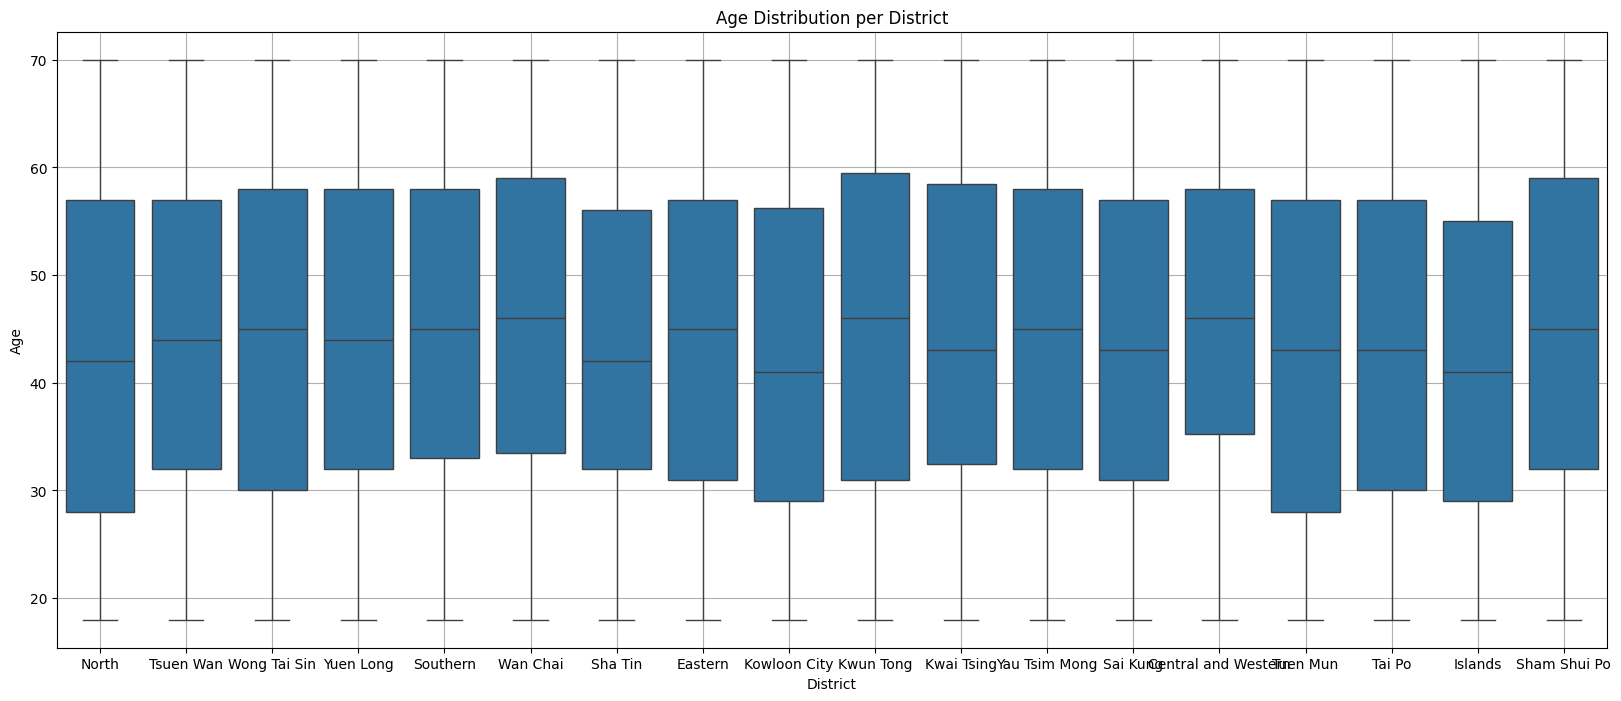

In [169]:
# Plotting
plt.figure(figsize=(20, 8))
sns.boxplot(x='District', y='Age', data=df)
plt.title('Age Distribution per District')
plt.xlabel('District')
plt.ylabel('Age')
plt.grid(True)
plt.show()